In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir, asum_input_dir
from reviews.preprocess import preprocess

pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152368 entries, 0 to 152367
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152368 non-null  object        
 1   overall      152368 non-null  int64         
 2   summary      152368 non-null  object        
 3   text         152368 non-null  object        
 4   timestamp    152368 non-null  datetime64[ns]
 5   vote         152368 non-null  int64         
 6   emoji        152368 non-null  object        
 7   brand        152368 non-null  object        
 8   category     152368 non-null  object        
 9   description  152368 non-null  object        
 10  price        152368 non-null  float64       
 11  title        152368 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 15.1+ MB


In [3]:
from reviews.preprocess import STOPWORDS
print(STOPWORDS)

{'except', 'against', 'show', 'whose', 'during', 'how', 'wherever', 'done', 'say', 'yours', 'almost', 'down', 'to', 'take', 'become', 'x', 'hereby', 'him', 'five', 'became', 'seems', 'no', 'still', 'very', 'first', 'an', 'alone', 'his', 'within', 'whereby', 'whoever', 'work', 'o', 'fifteen', 'neither', 'are', 'just', 'cannot', 'although', 'u', 'not', 'nothing', 'ours', 'upon', 'had', 'ever', 'we', 'thus', 'anyone', 'need', 'therein', 'more', 'so', 'whom', 'anyhow', 'else', 'shall', 'really', 's', 'itself', 'mine', 'where', 'perhaps', 'being', 'see', 'twelve', 'you', 'ourselves', 'nor', 'move', 'thence', 'ca', 'name', 'nine', 'themselves', 'latter', 'get', 'whither', 'd', 'becoming', 'than', 'other', 'latterly', 'nobody', 'rather', 'three', 'y', 'there', 'thereupon', 'the', 'what', 'were', 'various', 'can', 'never', 'of', 'must', 'regard', 'have', 'becomes', 'me', 'whereafter', 'eight', 'seeming', 'beforehand', 'however', 'anything', 'across', 'none', 'though', 'full', 'please', 'onto',

In [4]:
# apply preprocessing
reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

summary_text = []
for i, row in reviews_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
reviews_df["summary+text"] = summary_text

reviews_df["tokens"] = reviews_df["summary+text"].parallel_apply(
    lambda x: preprocess(x, lemmatization=True)
)

# save
reviews_df.to_json(
    processed_data_dir / "reviews_lemmatization.json.gz"
)  # attenti al nome!!!

In [5]:
tokens = [word for doc in reviews_df["tokens"] for sent in doc for word in sent]
c = Counter(tokens)

print("Tokens:", len(set(tokens)))

Tokens: 50297


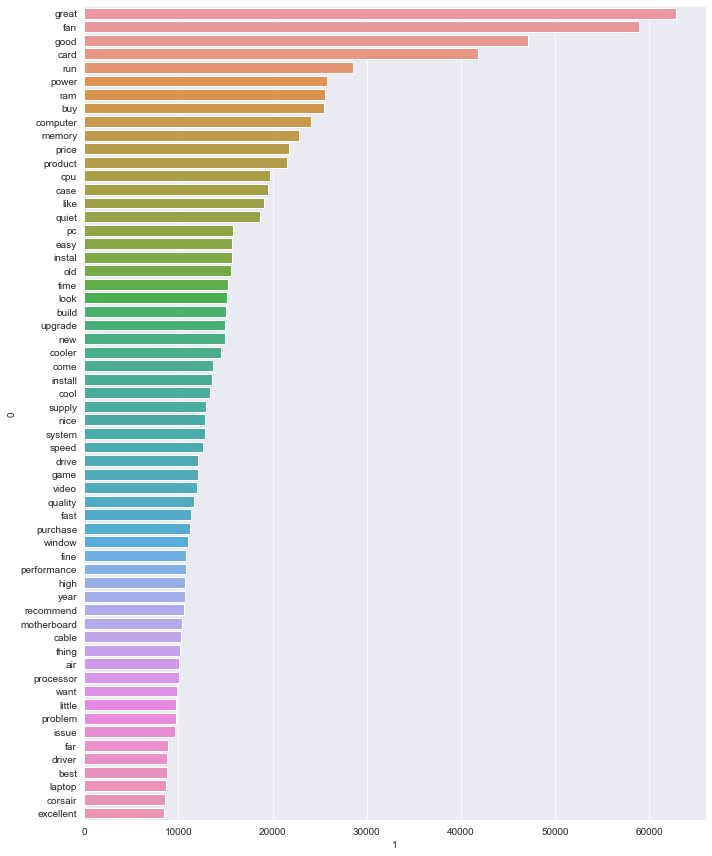

In [22]:
data = pd.DataFrame(Counter(tokens).most_common(60))
fig, ax = plt.subplots(figsize=(10, 12))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

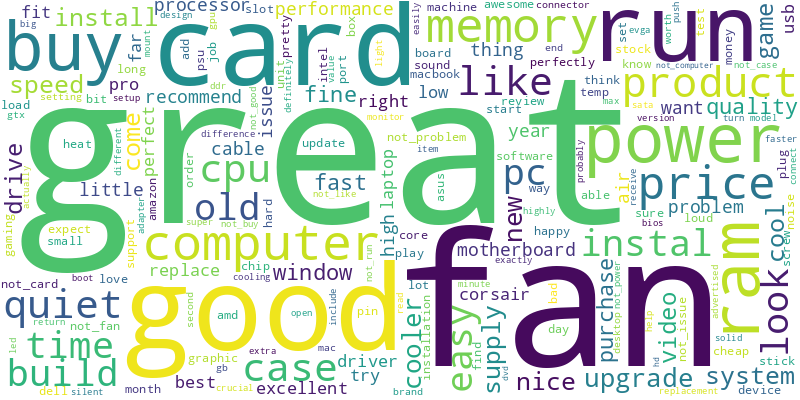

In [7]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(c)
wc.to_image()

In [8]:
# ground truth polarity
reviews_df["overall"] = reviews_df["overall"].parallel_apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)

In [9]:
positive_df = reviews_df[reviews_df["overall"] == "positive"]
positive_tokens = [
    word for doc in positive_df["tokens"] for sent in doc for word in sent
]
pos_c = Counter(positive_tokens)

print("positive tokens:", len(set(positive_tokens)))

negative_df = reviews_df[reviews_df["overall"] == "negative"]
negative_tokens = [
    word for doc in negative_df["tokens"] for sent in doc for word in sent
]
neg_c = Counter(negative_tokens)

print("negative tokens:", len(set(negative_tokens)))

positive tokens: 44288
negative tokens: 19543


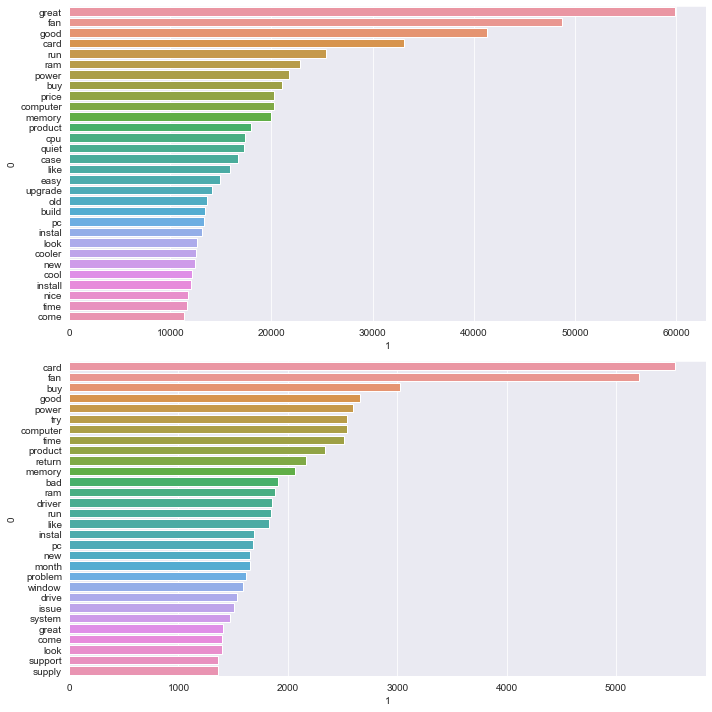

In [20]:
pos_data = pd.DataFrame(Counter(positive_tokens).most_common(30))
neg_data = pd.DataFrame(Counter(negative_tokens).most_common(30))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(y=pos_data[0], x=pos_data[1], ax=ax[0])
sns.barplot(y=neg_data[0], x=neg_data[1], ax=ax[1])
fig.tight_layout()

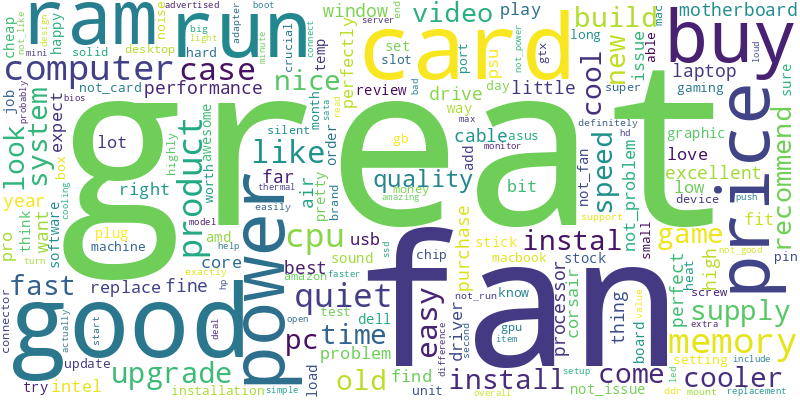

In [11]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(pos_c)
wc.to_image()

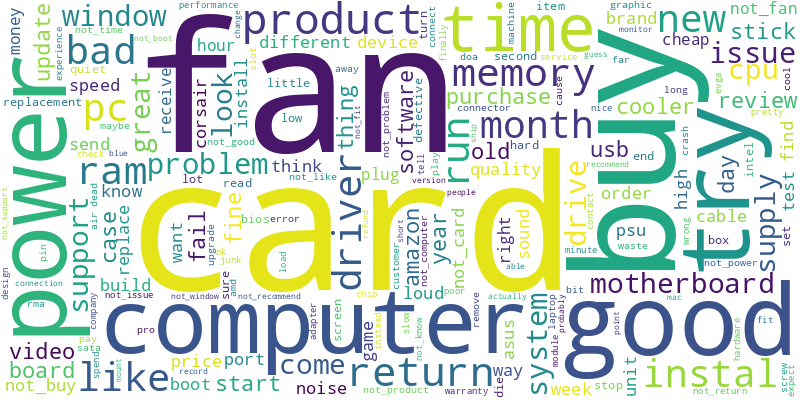

In [12]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(neg_c)
wc.to_image()

In [13]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print("Vocabulary size:", len(vocabulary))

# save vocabulary for asum input
np.save(asum_input_dir / "vocabulary", vocabulary)

Vocabulary size: 50297


# Look for bad results

In [ ]:
# check long words
Counter([t for t in tokens if len(t) < 3 and not t.startswith("not_")]).most_common()

In [15]:
strange_tokens = ["johnfixesstuffblogspotcom"]

In [16]:
for q in strange_tokens:
    for i, row in reviews_df.iterrows():
        if q in [t for s in row["tokens"] for t in s]:
            print(row["summary"] + " --- " + row["text"])
            print(row["tokens"])
            print("\n")